In [1]:
%load_ext autoreload
%autoreload 2

# Predicting the Beats-per-Minute of Songs

In [2]:
import numpy as np
import polars as pl

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')

# Load Train Dataset

In [3]:
train_data = pl.read_csv('../../data/playground-series-s5e9/train.csv')
train_data.head(2)

id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,0.60361,-7.636942,0.0235,0.000005,0.000001,0.051385,0.409866,290715.645,0.826267,147.5302
1,0.639451,-16.267598,0.07152,0.444929,0.349414,0.170522,0.65101,164519.5174,0.1454,136.15963


# Inspect

In [4]:
train_data.shape

(524164, 11)

In [5]:
train_data.glimpse(max_items_per_column=2)

Rows: 524164
Columns: 11
$ id                        <i64> 0, 1
$ RhythmScore               <f64> 0.603609719, 0.639451219
$ AudioLoudness             <f64> -7.636942085, -16.26759827
$ VocalContent              <f64> 0.0235, 0.071519503
$ AcousticQuality           <f64> 5.36e-06, 0.444929072
$ InstrumentalScore         <f64> 1.07e-06, 0.349414237
$ LivePerformanceLikelihood <f64> 0.051385456, 0.170522335
$ MoodScore                 <f64> 0.409866259, 0.651010252
$ TrackDurationMs           <f64> 290715.645, 164519.5174
$ Energy                    <f64> 0.826266667, 0.1454
$ BeatsPerMinute            <f64> 147.5302, 136.15963



In [6]:
train_data.schema

Schema([('id', Int64),
        ('RhythmScore', Float64),
        ('AudioLoudness', Float64),
        ('VocalContent', Float64),
        ('AcousticQuality', Float64),
        ('InstrumentalScore', Float64),
        ('LivePerformanceLikelihood', Float64),
        ('MoodScore', Float64),
        ('TrackDurationMs', Float64),
        ('Energy', Float64),
        ('BeatsPerMinute', Float64)])

# Plot Target

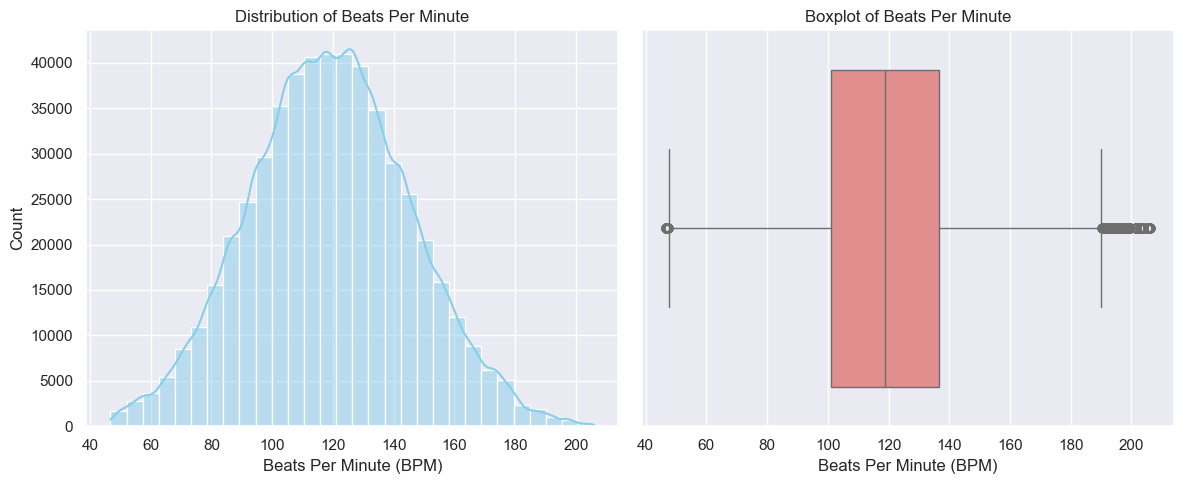

In [7]:
def plot_beats_per_minute(df):
    bpm = df["BeatsPerMinute"]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Histogram + KDE
    sns.histplot(bpm, bins=30, kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title("Distribution of Beats Per Minute")
    axes[0].set_xlabel("Beats Per Minute (BPM)")
    axes[0].set_ylabel("Count")

    # Boxplot
    sns.boxplot(x=bpm, ax=axes[1], color="lightcoral")
    axes[1].set_title("Boxplot of Beats Per Minute")
    axes[1].set_xlabel("Beats Per Minute (BPM)")

    plt.tight_layout()
    plt.show()

plot_beats_per_minute(train_data)

# Drop Columns

In [8]:
columns_to_drop = ['id']

train_data = train_data.drop(columns_to_drop)
train_data.glimpse(max_items_per_column=2)

Rows: 524164
Columns: 10
$ RhythmScore               <f64> 0.603609719, 0.639451219
$ AudioLoudness             <f64> -7.636942085, -16.26759827
$ VocalContent              <f64> 0.0235, 0.071519503
$ AcousticQuality           <f64> 5.36e-06, 0.444929072
$ InstrumentalScore         <f64> 1.07e-06, 0.349414237
$ LivePerformanceLikelihood <f64> 0.051385456, 0.170522335
$ MoodScore                 <f64> 0.409866259, 0.651010252
$ TrackDurationMs           <f64> 290715.645, 164519.5174
$ Energy                    <f64> 0.826266667, 0.1454
$ BeatsPerMinute            <f64> 147.5302, 136.15963



# Missing Values

In [9]:
train_data.null_count()

RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0
